# The purpose of this is to provide a time-series forecast model to predict if the number of positives a country/territory will receive within the next number of days will increase or decrease

> data from: https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide

In [1]:
# Import custom Time_Series python library and other imports
%run ./utils.ipynb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, TimeDistributed, GRU
from keras.optimizers import Adam
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

## Set start and end dates for train and test sets

In [2]:
str_train_start = '01/01/2020'
str_train_end = '11/01/2020'
str_test_start = str_train_end
str_test_end = '12/01/2020'
start_train_date = pd.to_datetime(str_train_start) # start of train data
end_train_date = pd.to_datetime(str_train_end) # end of train data
start_test_date = pd.to_datetime(str_test_start) # start of train data
end_test_date = pd.to_datetime(str_test_end) # end of train data
k = 17 # number of n-day components
n = 5 # n in n-day averages

## Define model evaluations

In [3]:
models = {} # trained models
Ps_test = {} # post processed predictions
Ts_test = {} # post processed truths

# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    aerror = np.zeros(y_true.shape, dtype=float)
    for i in range(y_true.shape[0]):
        if y_true[i] < 1:
            aerror[i] = y_pred[i]
        else:
            aerror[i] = np.abs((y_true[i] - y_pred[i]) / y_true[i])
    return np.mean(aerror)

# Measure how accurately model predicted if cases increase or decrease
def increase_decrease_accuracy(x_true, y_true, y_pred):
    n_correct = 0
    for i in range(y_true.shape[0]):
        if y_true[i] > x_true[i, -1]:
            if y_pred[i] > x_true[i, -1]:
                n_correct += 1
        elif y_true[i] < x_true[i, -1]:
            if y_pred[i] < x_true[i, -1]:
                n_correct += 1
    return n_correct / y_true.shape[0]

# plot and evalute model predictions
def evaluate(model_name, proc, X_test, Y_test, P_Test):
    r2 = r2_score(Y_test, P_Test)
    rmse = sqrt(mean_squared_error(Y_test, P_Test))
    mae = mean_absolute_error(Y_test, P_Test)
    mape = mean_absolute_percentage_error(Y_test, P_Test)
    ida = increase_decrease_accuracy(X_test, Y_test, P_Test)
    plt.scatter(np.log10(P_Test), np.log10(Y_test))
    max_order = int(max(np.log10(Y_test).max(), np.log10(P_Test).max())) + 2
    plt.plot([x for x in range(max_order)], [x for x in range(max_order)], color='green')
    plt.xticks(np.arange(0, max_order, 1))
    plt.yticks(np.arange(0, max_order, 1))
    plt.xlabel(r'log$_{10}$(Predicted)')
    plt.ylabel(r'log$_{10}$(Expected)')
    plt.title(model_name + ' ' + proc.title() + ' ' + r'Forecasts, $r^2$=' + str(round(r2, 4)))
    plt.show()
    print('r2', r2, 'rmse', rmse, 'mae', mae, 'mape', mape, 'ida', ida, '\n\n')

## Read, Mungle, Plot, and Process Data

In [4]:
# read data
data = readCOVID19('COVID-19-geographic-disbtribution-worldwide-2020-12-11.csv', days_min=100, cases_min=100)

# plot data
#plot5(data)

samples = {}
for_ARIMA = {}
# get trianing data (up to start_date)
samples['train'], for_ARIMA['train_raw'] = prepare_MLA(data, window_size=n, lags=k, sample_name='train'
                            ,outputs=1, label_type='next', deriv=False
                               , start_date=start_train_date, end_date=end_train_date)
# get testing data (between start_date and end_date)
samples['test'], for_ARIMA['test_raw'] = prepare_MLA(data, window_size=n, lags=k, sample_name='test'
                            ,outputs=1, label_type='next', deriv=False
                              , start_date=start_test_date, end_date=end_test_date)

In [5]:
# get X and Y for train and test
Xs_train = {'raw': np.array(samples['train']['Xs'])}
Ys_train = {'raw' : np.array(samples['train']['Ys']).flatten()}
Xs_test = {'raw' : np.array(samples['test']['Xs'])}
Ys_test = {'raw' : np.array(samples['test']['Ys']).flatten()}

# get statistics on train data
X_min = np.min(Xs_train['raw'])
X_max = np.max(Xs_train['raw'])
X_mean = np.mean(Xs_train['raw'])
X_std = np.std(Xs_train['raw'])

# define methods for forward and backward processing
reverses = {}
def preproc(base, name, func):
    Xs_train[name] = func(Xs_train[base])
    Ys_train[name] = func(Ys_train[base])
    Xs_test[name] = func(Xs_test[base])
    Ys_test[name] = func(Ys_test[base])
    for_ARIMA['train_' + name] = {}
    for country in for_ARIMA['train_' + base]:
        for_ARIMA['train_' + name][country] = func(for_ARIMA['train_' + base][country])
    for_ARIMA['test_' + name] = {}
    for country in for_ARIMA['test_' + base]:
        for_ARIMA['test_' + name][country] = func(for_ARIMA['test_' + base][country])

# raw
def reverse_raw(X):
    return X
reverses['raw'] = reverse_raw

# min max normalize between 0 and 1
def norm(X):
    return (X - X_min) / (X_max - X_min)
preproc('raw', 'norm', norm)
def reverse_norm(X):
    return X * (X_max - X_min) + X_min
reverses['norm'] = reverse_norm

# standardize to zero mean and unit variance 
def stand(X):
    return (X - X_mean) / X_std
preproc('raw', 'stand', stand)
def reverse_stand(X):
    return X * X_std + X_mean
reverses['stand'] = reverse_stand
        
# log10 to consider the large range of values
preproc('raw', 'log10', np.log10)
def reverse_log10(X):
    return np.power(10, X)
reverses['log10'] = reverse_log10

# get statistics on ln train data
X_log10_min = np.min(Xs_train['log10'])
X_log10_max = np.max(Xs_train['log10'])
X_log10_mean = np.mean(Xs_train['log10'])
X_log10_std = np.std(Xs_train['log10'])

# take log10 then min max normalize between 0 and 1
def log10_norm(X):
    retX = np.log10(X)
    return (retX - X_log10_min) / (X_log10_max - X_log10_min)
preproc('raw', 'log10_norm', log10_norm)
def reverse_log10_norm(X):
    retX = X * (X_log10_max - X_log10_min) + X_log10_min
    return np.power(10, retX)
reverses['log10_norm'] = reverse_log10_norm

# take log10 then standardize
def log10_stand(X):
    retX = np.log10(X)
    return (retX - X_log10_mean) / X_log10_std
preproc('raw', 'log10_stand', log10_stand)
def reverse_log10_stand(X):
    retX = X * X_log10_std + X_log10_mean
    return np.power(10, retX)
reverses['log10_stand'] = reverse_log10_stand
        
# ln to consider the large range of values
preproc('raw', 'ln', np.log)
def reverse_ln(X):
    return np.exp(X)
reverses['ln'] = reverse_ln

# get statistics on ln train data
X_ln_min = np.min(Xs_train['ln'])
X_ln_max = np.max(Xs_train['ln'])
X_ln_mean = np.mean(Xs_train['ln'])
X_ln_std = np.std(Xs_train['ln'])

# take ln then min max normalize between 0 and 1
def ln_norm(X):
    retX = np.log(X)
    return (retX - X_ln_min) / (X_ln_max - X_ln_min)
preproc('raw', 'ln_norm', ln_norm)
def reverse_ln_norm(X):
    retX = X * (X_ln_max - X_ln_min) + X_ln_min
    return np.exp(retX)
reverses['ln_norm'] = reverse_ln_norm

# take ln then standardize
def ln_stand(X):
    retX = np.log(X)
    return (retX - X_ln_mean) / X_ln_std
preproc('raw', 'ln_stand', ln_stand)
def reverse_ln_stand(X):
    retX = X * X_ln_std + X_ln_mean
    return np.exp(retX)
reverses['ln_stand'] = reverse_ln_stand

# preprare for RNN by casting X and Y in dimensions [N_samples, N_timesteps, N_features]
procs = ['raw', 'log10', 'log10_norm', 'log10_stand', 'ln', 'ln_norm', 'ln_stand']
for proc in procs:
    Xs_train[proc + '_rnn'] = np.expand_dims(Xs_train[proc], axis=2)
    Ys_train[proc + '_rnn'] = np.expand_dims(np.expand_dims(Ys_train[proc], axis=1), axis=2)
    Xs_test[proc + '_rnn'] = np.expand_dims(Xs_test[proc], axis=2)
    Ys_test[proc + '_rnn'] = np.expand_dims(np.expand_dims(Ys_test[proc], axis=1), axis=2)

# post_process model predictions by undoing processing and removing <1 values
def post_process(X, Y, P, proc):
    P = reverses[proc](P)
    drop_rows = [r for r in range(P.shape[0]) if P[r] <= 1]
    return np.delete(X, drop_rows, axis=0), np.delete(Y, drop_rows, axis=0), np.delete(P, drop_rows, axis=0)

## ARIMA

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


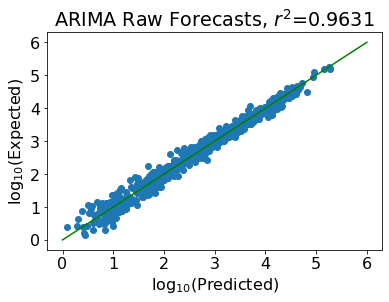

r2 0.9631005656103098 rmse 2714.336750576284 mae 744.3980424819723 mape 0.2568371941487686 ida 0.7680981595092025 




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\mod

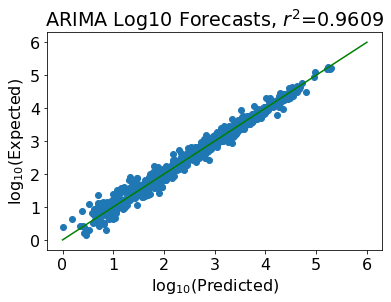

r2 0.9608821915549081 rmse 2794.73819323844 mae 747.3843398997965 mape 0.2531876046315728 ida 0.758282208588957 




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\mod

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Ma

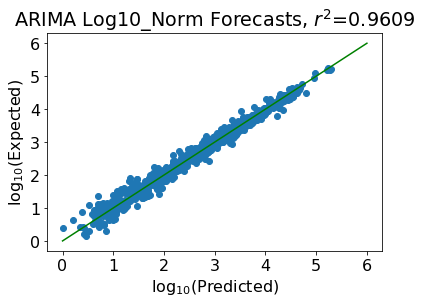

r2 0.9608539487378602 rmse 2795.746903091975 mae 747.3926138244824 mape 0.2531297160966447 ida 0.758282208588957 




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\mod

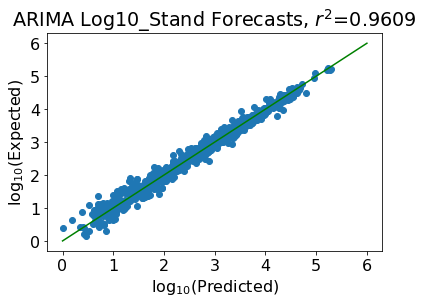

r2 0.9608867407535842 rmse 2794.575681719346 mae 746.7890009657095 mape 0.25297506430325567 ida 0.7595092024539877 




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\mod

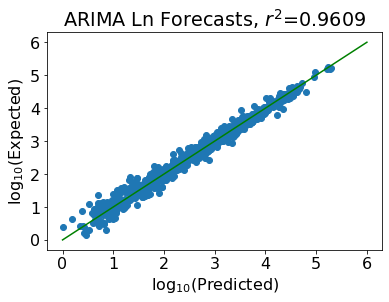

r2 0.9608746910072331 rmse 2795.0061154860955 mae 747.8041851762895 mape 0.2529473773305904 ida 0.7595092024539877 




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Ma

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Ma

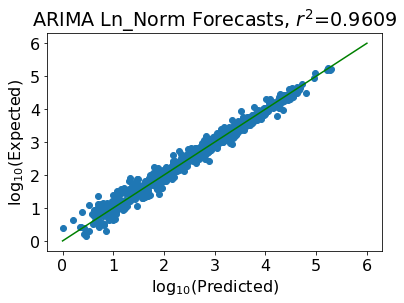

r2 0.9608608973132443 rmse 2795.498764140166 mae 746.2755650312382 mape 0.2525975809912536 ida 0.7619631901840491 




C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\s

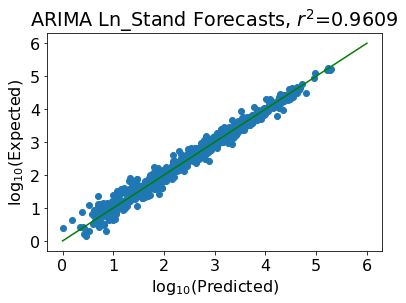

r2 0.9608828593676759 rmse 2794.7143374820985 mae 747.2808044553539 mape 0.25296866026198017 ida 0.758282208588957 




In [10]:
#### ARIMA trained on each country seperately
model_name = 'ARIMA'

for proc in procs:
    
    # now we need to step through each country, and train/evaluate an ARIMA for each
    preds = [] # keep track of forecasts
    truths = [] # keep track of expected values
    for country in for_ARIMA['test_' + proc]: # iterate through all data points
        if country not in for_ARIMA['train_' + proc]:
            continue
        
        # keep track of training and test values
        train_series = np.array(for_ARIMA['train_' + proc][country])
        test_series = np.array(for_ARIMA['test_' + proc][country])
        test_series_raw = np.array(for_ARIMA['test_raw'][country])
        
        # create and fit model
        for i in range(test_series.shape[0]):
            model_ARIMA = SARIMAX(train_series, order=(1, 1, 1))#, enforce_stationarity=False)
            model_ARIMA = model_ARIMA.fit(maxiter=1000)

            # make predictions, add to list
            preds.append(model_ARIMA.forecast(steps=1))
            truths.append(test_series_raw[i])

            # now append test values to predict next days
            train_series = np.append(train_series, test_series[i])
    
    # get predictions and post process
    returns = post_process(
        Xs_test['raw']
        , np.array(truths)
        , np.array(preds)
        , proc
    )
    Xs_test[proc + '_' + model_name] = returns[0]
    Ts_test[proc + '_' + model_name] = returns[1]
    Ps_test[proc + '_' + model_name] = returns[2]
    
    # evaluate model
    evaluate(
        model_name
        , proc
        , Xs_test[proc + '_' + model_name]
        , Ts_test[proc + '_' + model_name]
        , Ps_test[proc + '_' + model_name]
    )

In [ ]:
#### ARIMA trained on each country seperately
model_name = 'ARIMA'

for p in range(4):
    for d in range(4):
        for q in range(4):
            for enforce_stationarity in [True, False]:
                for enforce_invertibility in [True, False]:
                    str_params = str(p) + ' ' + str(d) + ' ' + str(q) + ' ' + str(enforce_stationarity) + ' ' + str(enforce_invertibility)
                    proc = 'raw'
                    # now we need to step through each country, and train/evaluate an ARIMA for each
                    preds = [] # keep track of forecasts
                    truths = [] # keep track of expected values
                    for country in for_ARIMA['test_' + proc]: # iterate through all data points
                        if country not in for_ARIMA['train_' + proc]:
                            continue

                        # keep track of training and test values
                        train_series = np.array(for_ARIMA['train_' + proc][country])
                        test_series = np.array(for_ARIMA['test_' + proc][country])
                        test_series_raw = np.array(for_ARIMA['test_raw'][country])

                        # create and fit model
                        for i in range(test_series.shape[0]):
                            model_ARIMA = SARIMAX(train_series, order=(p, d, q)
                            , enforce_stationarity=enforce_stationarity, enforce_invertibility=enforce_invertibility)
                            model_ARIMA = model_ARIMA.fit(maxiter=1000)

                            # make predictions, add to list
                            preds.append(model_ARIMA.forecast(steps=1))
                            truths.append(test_series_raw[i])

                            # now append test values to predict next days
                            train_series = np.append(train_series, test_series[i])

                    # get predictions and post process
                    returns = post_process(
                        Xs_test['raw']
                        , np.array(truths)
                        , np.array(preds)
                        , proc
                    )
                    Xs_test[proc + '_' + model_name] = returns[0]
                    Ts_test[proc + '_' + model_name] = returns[1]
                    Ps_test[proc + '_' + model_name] = returns[2]

                    # evaluate model
                    evaluate(
                        model_name
                        , str_params
                        , Xs_test[proc + '_' + model_name]
                        , Ts_test[proc + '_' + model_name]
                        , Ps_test[proc + '_' + model_name]
                    )